In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})



In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from utils import (
    get_prepared_train_test,
    get_anomaly_detection_report,
    get_detection_score,
    get_best_score_threshold,
)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def transform_dataset(df_raw, scaler, tp="licit"):
    if tp == "all":
        df = df_raw
    if tp == "illicit":
        df = df_raw[df_raw["class"] == 1]
    if tp == "licit":
        df = df_raw[df_raw["class"] == 2]
    if tp == "unknown":
        df = df_raw[df_raw["class"] == 3]
    if tp == "no_illicit":
        df = df_raw[df_raw["class"] != 1]
    df = df.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ])
    scaler = StandardScaler()
    df_transformed = scaler.fit_transform(df)

    return df_transformed

In [5]:
# Custom Dataset for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data  # TODO: preprocess

        # self.preprocess()
    
    def preprocess(self):
        raise NotImplementedError()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample, torch.tensor(0)

def get_dataloader(dataset, batch_size=64, shuffle=True):
    dataset = TabularDataset(dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [6]:
class BTCAddressVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar


In [7]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = nn.MSELoss()(recon_x, x)

    # KL divergence
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return recon_loss + beta * kl_div

In [8]:
import torch
from torch import nn, optim
from tqdm import tqdm

def plot_losses(train_loss, val_loss):
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs.plot(range(1, len(train_loss) + 1), train_loss, label="train")
    axs.plot(range(1, len(val_loss) + 1), val_loss, label="val")
    axs.set_ylabel('loss')

    axs.set_xlabel('epoch')

    plt.show()

def train_VAE(model, train_loader, val_loader, num_epochs=50, lr=1e-3, beta=1.0, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # You can also try nn.SmoothL1Loss()

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch[0]
            batch = batch.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch[0]
                val_batch = val_batch.to(device)

                val_recon, mu, logvar = model(val_batch)
                val_loss = vae_loss(val_recon, val_batch, mu, logvar, beta)

                total_val_loss += val_loss.item() * val_batch.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        plot_losses(train_losses, val_losses)

    print("✅ Training complete.")



In [9]:
train_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_full = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

train_data_full = train_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])
test_data_full = test_data_full.drop(columns=[
    'userId',
       'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
       'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_transacted_total',
       'user_btc_sent_total', 'user_btc_received_total',
       'user_btc_sent_median', 'user_btc_received_median',
       'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
       'user_user_ts_fees_share_max', 'user_whole_fee_5',
])


scaler = StandardScaler()
scaler.fit(train_data_full.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ]))

train_data = transform_dataset(train_data_full, scaler, tp="no_illicit")
test_data = transform_dataset(test_data_full, scaler, tp="all")
test_labels = test_data_full["class"]

train_data, val_data = train_test_split(
    train_data,
    test_size=0.15
)
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)

In [10]:
train_data.shape

(461184, 35)

In [11]:
# vae = BTCAddressVAE(input_dim=35)

# train_VAE(
#     vae,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device="cpu",
#     lr=0.00001,
#     num_epochs=150
# )

In [12]:
# torch.save(vae, "./vae_wallets_150ep.pth")

vae = torch.load("./vae_wallets_150ep.pth")

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_2473/425442199.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load("./vae_wallets_150ep.pth")


In [13]:

def compute_reconstruction_errors(model, X_np, device='cuda'):
    model.eval()
    X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon, mu, logvar = model(X_tensor)

        recon_loss = torch.mean((X_tensor - recon) ** 2, dim=1)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

        elbo = recon_loss + kl_div
        elbo_scores = elbo.cpu().numpy()

    return elbo_scores

def get_licit_illicit_recon_errors(
        model,
        licit_dataset,
        illicit_dataset,
        unk_dataset=None,
        cnt=20,
        plot=False,
        stat="count"
):
    licit_idxs = np.random.choice(licit_dataset.shape[0], cnt if cnt is not None else licit_dataset.shape[0], replace=False)
    illicit_idxs = np.random.choice(illicit_dataset.shape[0], cnt if cnt is not None else illicit_dataset.shape[0], replace=False)
    licit_errs = compute_reconstruction_errors(
        model,
        licit_dataset[licit_idxs],
        device="cpu"
    )
    illicit_errs = compute_reconstruction_errors(
        model,
        illicit_dataset[illicit_idxs],
        device="cpu"
    )

    if unk_dataset is not None:
        unk_idxs = np.random.choice(unk_dataset.shape[0], cnt if cnt is not None else unk_dataset.shape[0], replace=False)
        unk_errs = compute_reconstruction_errors(
            model,
            unk_dataset[unk_idxs],
            device="cpu"
        )

    if plot:
        sns.histplot(licit_errs[licit_errs<0.8], label="Licit", bins=30, stat=stat)
        sns.histplot(illicit_errs[illicit_errs<0.8], label="Illicit", bins=30, stat=stat)
        
        if unk_dataset is not None:
            sns.histplot(unk_errs[unk_errs<0.8], label="Unknown", bins=30, alpha=0.5, stat=stat)
        plt.legend()
        
    return licit_errs, illicit_errs

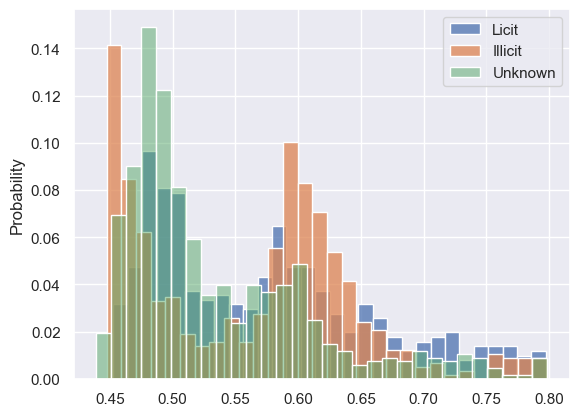

In [15]:
_ = get_licit_illicit_recon_errors(
    vae,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    test_data[test_labels == 3],
    cnt=1000,
    plot=True,
    stat="probability"
)

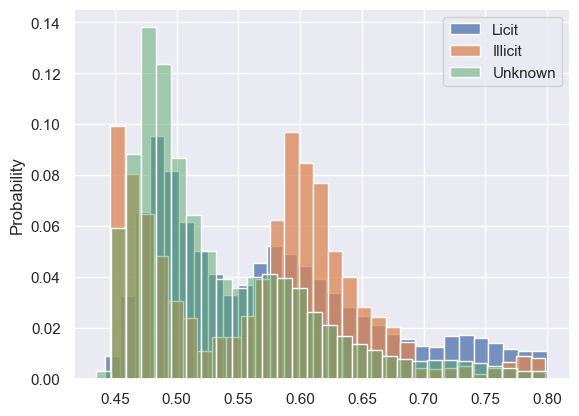

In [34]:
_ = get_licit_illicit_recon_errors(
    vae,
    test_data[test_labels == 2],
    test_data[test_labels == 1],
    test_data[test_labels == 3],
    cnt=None,
    plot=True,
    stat="probability"
) 

	real 1	real 0
pred 1	3294	151803	
pred 0	1211	124726	
Precicion 0.021238321824406662, Recall 0.7311875693673696, Acc=0.455532070852637
[0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.016030830436159577, 0.01604601877081441, 0.015647149014956462, 0.015410717335293549, 0.015430455713558043, 0.015712812942512044, 0.016318030912085755, 0.016954516683244415, 0.01750580283187689, 0.018065992638863434, 0.018584189048896565, 0.01909771007746184, 0.019491571654574217, 0.01986028391025928, 0.020139222825215818, 0.020419277390642386, 0.020727036988126824, 0.020941536411749468, 0.02118169555368914, 0.021287366296537352, 0.021066558111133726, 0.02059595924227039, 0.020051769761556267, 0.019456749221656078, 0.018954371904887916, 0.018732654949121186, 0.018495568279865086, 0.018348550695745782, 0.018179169229773043, 0.017971979788700045, 0.017807456872565387, 0.017707957245652776, 0.017706619629924866, 0.01766730008730933, 0.017699649631509

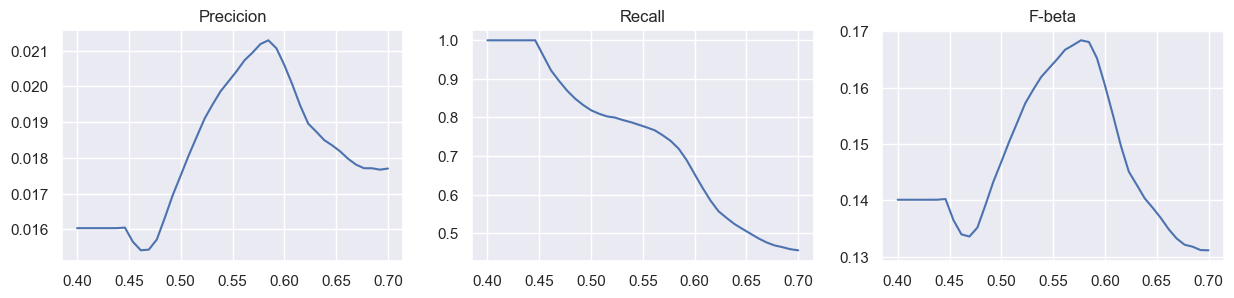

In [17]:
licit_scores=compute_reconstruction_errors(vae, test_data[test_labels == 2], "cpu")
illicit_scores=compute_reconstruction_errors(vae, test_data[test_labels == 1], "cpu")
unknown_scores=compute_reconstruction_errors(vae, test_data[test_labels == 3], "cpu")

get_best_score_threshold(
    licit_scores,
    illicit_scores,
    unknown_scores,
    plot=True,
    thr_interval=(0.4,0.7)
)


	real 1	real 0
pred 1	1820	72368	
pred 0	2685	204161	
Precicion 0.024532269369709387, Recall 0.4039955604883463, Acc=0.7329397866450322
[0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024532269369709387, 0.024

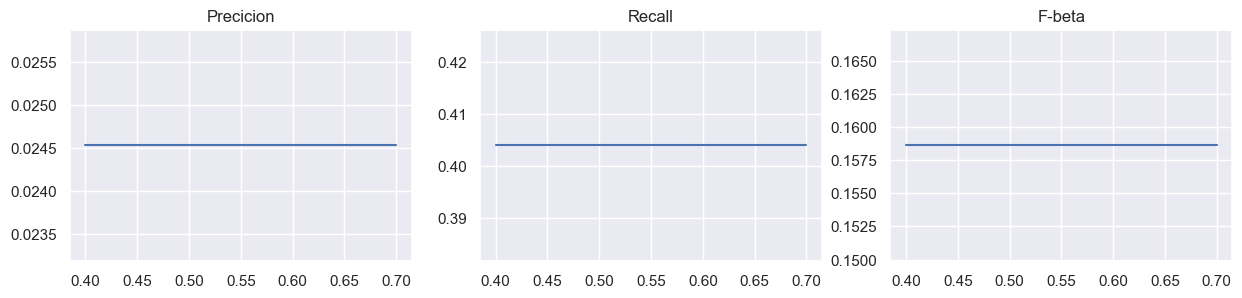

In [23]:
l = 0.58
r = 0.68
get_best_score_threshold(
    (((licit_scores >= l) & (licit_scores <= r)) | ((licit_scores <= 0.48))),
    (((illicit_scores >= l) & (illicit_scores <= r)) | ((illicit_scores <= 0.48))),
    (((unknown_scores >= l) & (unknown_scores <= r)) | ((unknown_scores <= 0.48))),
    plot=True,
    thr_interval=(0.4,0.7)
)
